In [1]:
import skimage
from skimage import io
import cv2
import matplotlib.pyplot as plt
import tifffile as tfl
import os
import sys
import numpy as np
import scipy.io
from skimage import img_as_float, img_as_uint
from joblib import parallel, delayed
from scipy.linalg import solve
from skimage.util import view_as_blocks
from scipy.signal import convolve2d , correlate2d, fftconvolve
import shutil
import glob
from joblib import dump, load
from skimage.morphology import disk
from skimage.filters import median, difference_of_gaussians
from skimage.registration import phase_cross_correlation as pcc
from skimage.exposure import match_histograms
from scipy.ndimage import shift
import time
import bardensr

In [2]:

pth='/mnt/d/allen_data/test_dataset_bc_726126/processed/MAX_Pos1_000_003/original/'

config_pth='/mnt/c/Users/goswami/Documents/MATLAB/barseq-matlab-allen-main (1)/barseq-matlab-allen-main/config/'
cyclename='n2vgene'
is_affine=0
num_initial_c=5 # initial channels in first round of sequencing to read
num_later_c=4 # subsequent cycle channels to read
num_c=4 # channels to perform bleedthrough-correction and channel alignment, needs more elegant solution--ng
subsample_rate=4
do_coarse=0
resize_factor=2
block_size=128
chshift_filename='chshift20x-20220218.mat'
chprofile_filename='chprofile20x-50-30-20-40-20220218.mat'
radius=31
local=1

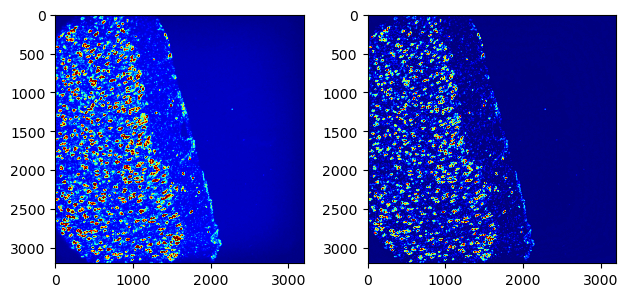

In [33]:
I=tfl.imread(os.path.join(pth,'n2vgeneseq02.tif'),key=range(0,4,1))
Ifilt=back_sub_opencv_open(I,31,pth,'bcksb.tif',4,0)

fg, ax=plt.subplots(1,2)
ax[0].imshow(I[3,:,:],cmap='jet',vmin=0,vmax=150)
ax[1].imshow(Ifilt[3,:,:],cmap='jet',vmin=0,vmax=150)
plt.tight_layout()


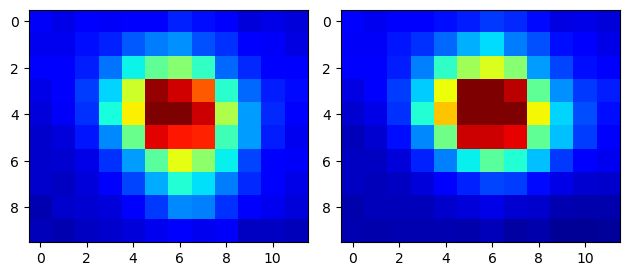

In [53]:
Ialigned=channel_alignment(Ifilt,chshift_filename,config_pth,pth,'aligned.tif',4,0,0)
fg, ax=plt.subplots(1,2)
ax[0].imshow(np.sum(Ifilt[:,362:372,450:462],axis=0),cmap='jet',vmin=0,vmax=150)
ax[1].imshow(np.sum(Ialigned[:,362:372,450:462],axis=0),cmap='jet',vmin=0,vmax=150)
plt.tight_layout()

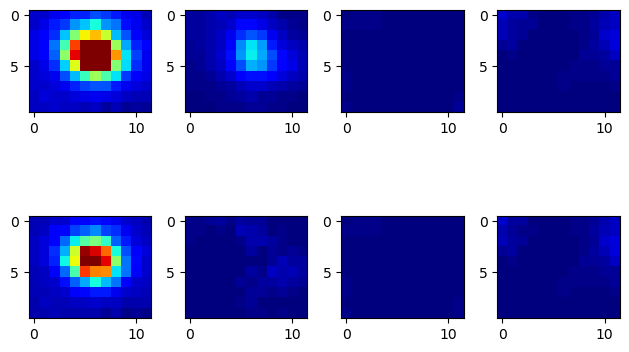

In [63]:
Icorr=bleedthrough_linear(Ialigned,4,config_pth,chprofile_filename,pth,'corr.tif',0)
fg, ax=plt.subplots(2,4)
for i in range(4):
    ax[0,i].imshow(Ialigned[i,362:372,450:462],cmap='jet',vmin=0,vmax=100)
    ax[1,i].imshow(Icorr[i,362:372,450:462],cmap='jet',vmin=0,vmax=100)
plt.tight_layout()

In [ ]:
# # background removal using rolling ball-skimage-very slow
# radius=10
# bk=skimage.morphology.ball(radius)
# I_filtered=I[:,:,::-1]-skimage.morphology.opening(I[:,:,::-1],footprint=bk)
# io.imshow(I_filtered[3,:,:],cmap='gray',vmin=20,vmax=150)
# io.imshow(I_filtered[3,:,:],cmap='gray',vmin=20,vmax=150)
# tfl.imwrite(pth+'hybbck.tif',I_filtered[:,:,::-1])


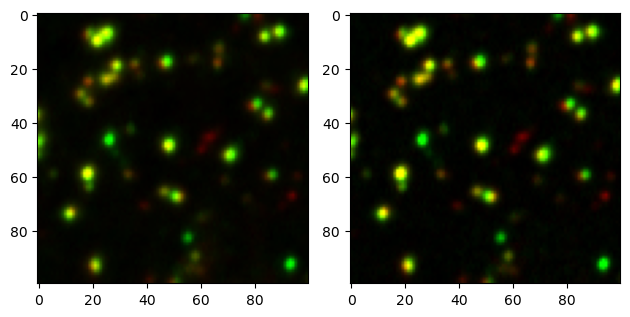

In [105]:
#CHECK GENESEQ CYCLE ALIGNEMENT
pth='/mnt/d/allen_data/test_dataset_bc_726126/processed/MAX_Pos1_000_003/aligned/'
I1=np.sum(tfl.imread(os.path.join(pth,'alignedn2vgeneseq01.tif'),key=range(0,4,1)),axis=0)
I2=np.sum(tfl.imread(os.path.join(pth,'alignedn2vgeneseq07.tif'),key=range(0,4,1)),axis=0)
I_rgb=np.zeros((3,I1.shape[0],I1.shape[1]))
I_rgb[0,:,:]=np.double(np.divide(I1,np.max(I1,axis=None)))*10
I_rgb[1,:,:]=np.double(np.divide(I2,np.max(I2,axis=None)))*10


Irgb=np.uint8(np.clip(I_rgb*255,0,255))

pthb='/mnt/d/allen_data/test_dataset_bc_726126/726126_test_dataset_processed/processed/MAX_Pos1_000_003/aligned/MAX_Pos1_000_003/aligned'
I1b=np.sum(tfl.imread(os.path.join(pthb,'alignedfixedn2vgeneseq01.tif'),key=range(0,4,1)),axis=0)
I2b=np.sum(tfl.imread(os.path.join(pthb,'alignedfixedn2vgeneseq07.tif'),key=range(0,4,1)),axis=0)
I_rgbb=np.zeros((3,I1b.shape[0],I1b.shape[1]))
I_rgbb[0,:,:]=np.double(np.divide(I1b,np.max(I1b,axis=None)))*10
I_rgbb[1,:,:]=np.double(np.divide(I2b,np.max(I2b,axis=None)))*10


Irgbb=np.uint8(np.clip(I_rgbb*255,0,255))


fg, ax=plt.subplots(1,2)
ax[0].imshow(np.transpose(Irgb[:,1450:1550,1350:1450],(1,2,0)),vmin=0,vmax=1)
ax[1].imshow(np.transpose(Irgbb[:,1450:1550,1350:1450],(1,2,0)),vmin=0,vmax=1)
plt.tight_layout()



In [127]:
def minmax_norm(x):
    y=np.divide((x-np.min(x,axis=None)),np.max(x,axis=None)-np.min(x,axis=None))
    return y

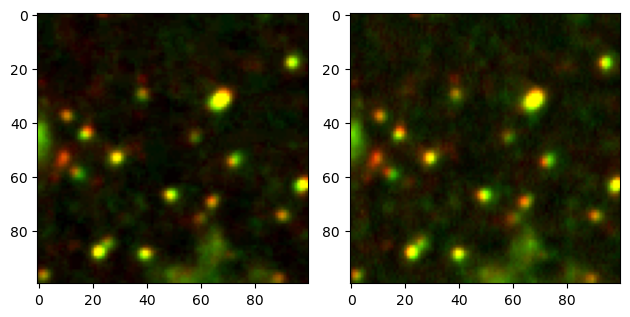

In [126]:
#CHECK BCSEQ CYCLE ALIGNEMENT
pth='/mnt/d/allen_data/test_dataset_bc_726126/processed/MAX_Pos1_000_003/aligned/'
I1=np.sum(tfl.imread(os.path.join(pth,'alignedregn2vbcseq01.tif'),key=range(0,4,1)),axis=0)
I2=np.sum(tfl.imread(os.path.join(pth,'alignedregn2vbcseq05.tif'),key=range(0,4,1)),axis=0)
I_rgb=np.zeros((3,I1.shape[0],I1.shape[1]))
I_rgb[0,:,:]=np.double(np.divide(I1,np.max(I1,axis=None)))*10
I_rgb[1,:,:]=np.double(np.divide(I2,np.max(I2,axis=None)))*10


Irgb=np.uint8(np.clip(I_rgb*255,0,255))

pthb='/mnt/d/allen_data/test_dataset_bc_726126/726126_test_dataset_processed/processed/MAX_Pos1_000_003/aligned/MAX_Pos1_000_003/aligned'
I1b=np.sum(tfl.imread(os.path.join(pthb,'alignedfixedregn2vbcseq01.tif'),key=range(0,4,1)),axis=0)
I2b=np.sum(tfl.imread(os.path.join(pthb,'alignedfixedregn2vbcseq05.tif'),key=range(0,4,1)),axis=0)
I_rgbb=np.zeros((3,I1b.shape[0],I1b.shape[1]))
I_rgbb[0,:,:]=np.double(np.divide(I1b,np.max(I1b,axis=None)))*10
I_rgbb[1,:,:]=np.double(np.divide(I2b,np.max(I2b,axis=None)))*10


Irgbb=np.uint8(np.clip(I_rgbb*255,0,255))


fg, ax=plt.subplots(1,2)
ax[0].imshow(np.transpose(Irgb[:,1450:1550,1350:1450],(1,2,0)),vmin=0,vmax=1)
ax[1].imshow(np.transpose(Irgbb[:,1450:1550,1350:1450],(1,2,0)),vmin=0,vmax=1)
# ax[0].imshow(np.transpose(Irgb[:,:.:],(1,2,0)),vmin=0,vmax=1)
# ax[1].imshow(np.transpose(Irgbb[:,:.:],(1,2,0)),vmin=0,vmax=1)
plt.tight_layout()

In [ ]:
#HYB FINAL LAYER-----------------develop
pthb='/mnt/d/allen_data/test_dataset_bc_726126/'
folders,_,_,_=get_folders(pthb)
for i in range(len(folders)):
    pthl=os.path.join(pthb,'processed',folders[i])
    [shutil.move(f1,os.path.join(pth,'original/'+f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pth,cycle_name+'*.tif'))]

    process_hyb_images(pthl,config_pth,chshift_hyb_filename,chprofile_hyb_filename,cycle_name='n2vhyb',ref_cycle_name='alignedn2vgene',reg_cycle=1,dapi_shift=[],dapi_ch_num=5,num_c_hyb=6,num_c=4,is_affine=0,radius=31,ch_i=2)

In [125]:
pthb='/mnt/d/allen_data/test_dataset_bc_726126'

process_bc_images(pthb,config_pth,chshift_filename,chprofile_filename,is_affine=0,num_initial_c=5,num_later_c=4,num_c=4,subsample_rate=4,do_coarse=0,resize_factor=2,block_size=128,radius=31,local=1,cyclename='regn2vbc',bcidx=4,geneidx=4,ch_bc=4,ch_bc_init=5,bcfname='n2vbcseq',genefname='n2vgene',strength=0.6,m=0)



BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_000_000
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_000_001
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_000_002
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_000_003
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_000_004
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_001_000
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_001_001
BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER MAX_Pos1_

In [ ]:
# BARDENSR CALL
t0=time.time()
pth='/mnt/d/allen_data/test_dataset_bc_726126/'
bardensr_call(pth,config_pth,num_channels=4,codebook_name='codebookM1all.mat',fdrthresh=0.05,trim=160,cropf=0.4,noisefloor_ini=0.01,noisefloor_final=0.05)
tn=time.time()
print(f'Total time for {len(folders)} is {tn-t0} secs')

In [434]:
def image_reader_trimmed(pthb,trim,R,C):
    I=[]
    for i in range(1,R+1):
        for j in range(C):
            I.append(np.expand_dims(tfl.imread(os.path.join(pthb,'alignedn2vgeneseq'+'%0.2d'%i+'.tif'),key=j),axis=0))
    I=np.array(I)

    return(I[:,:,trim:-trim,trim:-trim])

In [435]:
def image_reader_cropped(pthb,R,C,cropf=0.4):
    I=[]
    for i in range(1,R+1):
        for j in range(C):
            I.append(np.expand_dims(tfl.imread(os.path.join(pthb,'alignedn2vgeneseq'+'%0.2d'%i+'.tif'),key=j),axis=0))
    I=np.array(I)
    nx=np.size(I,3)
    ny=np.size(I,2)
    return(I[:,:,round(ny*cropf):round(ny*(1-cropf)),round(nx*cropf):round(nx*(1-cropf))])

In [19]:
def uint16m(x):
    y=np.uint16(np.clip(np.round(x),0,65535))
    return y

In [20]:
def organize_geneseq_ng(pth='D:/HTNA24_new/',cyclename='geneseq'):
    print('Copying geneseq files in the correct folders...')
    genefolders=sorted(glob.glob(os.path.join(pth,cyclename+"*")))
    #print(genefolders)
    for f,i in enumerate(genefolders):
        if not(os.path.isdir(f)):
            f=[]
    
    try:
        os.makedirs(os.path.join(pth,'processed'),exist_ok=True)
        #print(pthw)
    except Exception:
        print('Directory already exists\n')
    for i,f2 in enumerate(genefolders):
        print(f'Organizing folder {genefolders[i]}\n')
        files=sorted(glob.glob(os.path.join(pth,genefolders[i],'MAX*.tif')))
        for j,f1 in enumerate(files):
            name=f1.split('MAX')
            fname=name[1].split('.')
            os.makedirs(os.path.join(pth,'processed','MAX'+fname[0]),exist_ok=True)
            shutil.copy(f1,os.path.join(pth,'processed','MAX'+fname[0],cyclename+f2.partition(cyclename)[-1]+'.tif'))
            print(f'Copied {j}')
            

In [21]:
def get_folders(pth):
    dr=sorted(glob.glob(os.path.join(pth,'processed','MAX*')))
    folder=[]
    xp=[]
    yp=[]
    pos=[]
    for i,j in enumerate(dr):
        folder.append(str(j).split('/')[-1])
        temp=str(j).split('/')[-1].split('_')
        pos.append(temp[1])
        xp.append(int(temp[2])+1)
        yp.append(int(temp[3])+1)
    return folder,pos,xp,yp

In [22]:
def back_sub_opencv_open(I,radius,pth,name,num_c,writefile):
    I=I.copy()
    I_filtered=np.zeros_like(I)
    I_rem=I[num_c:,:,:]
    I=I[0:num_c,:,:]
    k=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(radius,radius))
    for i in range(len(I)):
        bck=cv2.morphologyEx(I[i,:,:], cv2.MORPH_OPEN, kernel= k)
        I_filtered[i,:,:]=I[i,:,:]-np.expand_dims(bck,0)
    
    I_filtered[num_c:,:,:]=I_rem    
    I_filtered=uint16m(I_filtered)
    if writefile:
        tfl.imwrite(os.path.join(pth,name),I_filtered,photometric='minisblack')
    return I_filtered

In [23]:
def channel_alignment(I_filtered,fname,config_pth,pth,name,num_c,is_affine,writefile):
    I_filtered=I_filtered.copy()
    Ishifted=np.zeros_like(I_filtered)
    I_rem=I_filtered[num_c:,:,:]
    I_filtered=I_filtered[0:num_c,:,:]
    chshift=scipy.io.loadmat(os.path.join(config_pth,fname))['chshift20x']
    for i in range(chshift.shape[0]):
        if is_affine:
            tform=chshift[i] # refine this later on-ng
        else:
            tform=skimage.transform.SimilarityTransform(translation=-chshift[i,:]) # remember this takes -shifts-ng
            
        It=skimage.transform.warp(np.squeeze(I_filtered[i,:,:]),tform,preserve_range=True,output_shape=(I_filtered.shape[1],I_filtered.shape[2]))
        Ishifted[i,:,:]=np.expand_dims(It,0)
    Ishifted[num_c:,:,:]=I_rem    
    Ishifted=uint16m(Ishifted)
    if writefile:
        tfl.imwrite(os.path.join(pth,name),Ishifted,photometric='minisblack')
    return Ishifted

In [24]:
def bleedthrough_linear(Is,num_c,config_pth,fname,pth,name,writefile):
    Is=Is.copy()
    Icorrected=np.zeros_like(Is)
    chprofile=scipy.io.loadmat(os.path.join(config_pth,fname))['chprofile20x']
    Ishifted2=np.float64(Is[0:num_c,:,:])
    I_rem=Is[num_c:,:,:]
    Icorrected=(np.reshape((np.linalg.solve(np.transpose(chprofile),((np.reshape(Ishifted2,(num_c,-1),order='F'))))),(num_c,Ishifted2.shape[1],Ishifted2.shape[2]),order='F'))
    Icorrected=uint16m(Icorrected)
    Icorrected=np.append(Icorrected,I_rem,axis=0)
    if writefile:
        tfl.imwrite(os.path.join(pth,name),Icorrected,photometric='minisblack')
    return Icorrected

In [25]:
def geneseq_cycle_alignment_block_correlation(imagename,templatename,subsample_rate,do_coarse,resize_factor,block_size,num_c,numcr,pth,folder,name):
    os.makedirs(os.path.join(pth,folder),exist_ok=True)
        
    moving=tfl.imread(os.path.join(pth,imagename),key=range(0,num_c,1))
    fixed=tfl.imread(os.path.join(pth,templatename),key=range(0,num_c,1))
    moving_sum=np.double(np.sum(moving,axis=0))
    moving_sum=np.divide(moving_sum,np.max(moving_sum,axis=None))
    fixed_sum=np.double(np.sum(fixed,axis=0))
    fixed_sum=np.divide(fixed_sum,np.max(fixed_sum,axis=None))
    sz=fixed_sum.shape
    b_x=np.floor(sz[0]/block_size)
    b_y=np.floor(sz[1]/block_size)


    if b_x*block_size!=sz[0]:
        fixed_sum=fixed_sum[0:b_x*block_size-1,:]
        moving_sum=moving_sum[0:b_x*block_size-1,:]

    if b_y*block_size!=sz[1]:
        fixed_sum=fixed_sum[:,0:b_y*block_size-1]
        moving_sum=moving_sum[:,0:b_y*block_size-1]
        
    moving_rescaled=np.uint8(skimage.transform.rescale(moving_sum,resize_factor)*255) # check if this uint8 needs to be changed as per matlab standard-ng
    fixed_rescaled=np.uint8(skimage.transform.rescale(fixed_sum,resize_factor)*255)
    moving_split=view_as_blocks(moving_rescaled, block_shape=(block_size*resize_factor,block_size*resize_factor))
    fixed_split=view_as_blocks(fixed_rescaled, block_shape=(block_size*resize_factor,block_size*resize_factor))
    fixed_split_lin=np.reshape(fixed_split,(-1,fixed_split.shape[2],fixed_split.shape[3]))
    
    fixed_split_sum=[np.sum(j,axis=None) for i,j in enumerate(fixed_split_lin)]
    idx=np.argsort(fixed_split_sum)[::-1]
    fixed_split_sum=np.reshape(fixed_split_sum,(fixed_split.shape[0],fixed_split.shape[1]))
   
    moving_split_lin=np.reshape(moving_split,(-1,moving_split.shape[2],moving_split.shape[3]))
    
    xcorr2=lambda a,b: fftconvolve(a,np.rot90(b,k=2))
    c=np.zeros((fixed_split_lin.shape[1]*2-1,fixed_split_lin.shape[2]*2-1))
    for i in range(np.int32(np.round(fixed_split_lin.shape[0]/subsample_rate))): # check for int32-ng
        if np.max(fixed_split_lin[idx[i]],axis=None)>0:
            c=c+xcorr2(np.double(fixed_split_lin[idx[i]]),np.double(moving_split_lin[idx[i]]))

    shift_yx=np.unravel_index(np.argmax(c),c.shape)

    yoffset=-np.array([(shift_yx[0]+1-fixed_split_lin.shape[1])/resize_factor])
    xoffset=-np.array([(shift_yx[1]+1-fixed_split_lin.shape[2])/resize_factor])

    idx_minxy=np.argmin(np.abs(xoffset)+np.abs(yoffset))

    tform=skimage.transform.SimilarityTransform(translation=[xoffset[idx_minxy], yoffset[idx_minxy]])

    moving_aligned=np.zeros_like(moving)
    for i in range(moving.shape[0]):
        moving_aligned[i,:,:]=np.expand_dims(skimage.transform.warp((np.squeeze(moving[i,:,:])),tform,preserve_range=True),0)#,output_shape=(moving.shape[1],moving.shape[2])),0)# check if output size specification is necessary -ng

    moving_aligned=uint16m(moving_aligned)
    moving_aligned_full=moving_aligned.copy()
    if numcr>num_c:
        moving_last_frame=tfl.imread(os.path.join(pth,imagename),key=range(num_c,numcr,1))
        if moving_last_frame.ndim==2:
            moving_last_frame=np.expand_dims(moving_last_frame,axis=0)
        moving_aligned_full=np.append(moving_aligned_full,moving_last_frame,axis=0)
        
    tfl.imwrite(os.path.join(pth,folder,name),moving_aligned_full,photometric='minisblack')
    return moving_aligned, tform

In [26]:
# have not included default zeros shiftmat on non-existent input--ng
def mmseqalignmentsinglethread_local_subsample(pth,config_pth,cyclename,num_initial_c,num_later_c,resize_factor,block_size,chshift_filename,chprofile_filename,radius,is_affine=0,num_c=4,subsample_rate=1,do_coarse=0):
    cycle_im=sorted(glob.glob(os.path.join(pth,cyclename+"*")))
    os.makedirs(os.path.join(pth,'original'),exist_ok=True)
    os.makedirs(os.path.join(pth,'aligned'),exist_ok=True)
    fixed_filename=cycle_im.copy()
    gtforms=[]

    for i in range(len(cycle_im)):

        filename=fixed_filename[i].split("/")[-1]
        fixed_filename[i]='fixed'+filename
        if i==0:
            num_cr=num_initial_c
            templatename=fixed_filename[i]
        else:
            num_cr=num_later_c

        I=tfl.imread(cycle_im[i],key=range(0,num_cr,1))

        if radius>0:
            Ibcksub=back_sub_opencv_open(I,radius,pth,filename,num_c,0) #BACKGROUND SUBTRACTION-NG
        else:
            Ibcksub=I
    
        Ibcksub_shifted=channel_alignment(Ibcksub,chshift_filename,config_pth,pth,'bck_sub'+filename,num_c,is_affine,0) # last argument is to not to write intermediate file-ng CHANNEL ALIGN-NG
        Ibcksub_shifted_btcorr=bleedthrough_linear(Ibcksub_shifted,num_c,config_pth,chprofile_filename,pth,fixed_filename[i],1) # BLEEDTHROUGH CORRECTION-NG
        _,gtforms_ind=geneseq_cycle_alignment_block_correlation(fixed_filename[i],templatename,subsample_rate,do_coarse,resize_factor,block_size,num_c,num_cr,pth,'aligned','aligned'+filename)
        gtforms.append(gtforms_ind)

    dump(gtforms,os.path.join(pth,'tforms'+cyclename+'.joblib'))
    [os.remove(f) for f in glob.glob(os.path.join(pth,'fixed*.tif'))]
    [shutil.move(f1,os.path.join(pth,'original/'+f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pth,cyclename+'*.tif'))]
    print(f'BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND CYCLE ALIGNEMENT COMPLETE FOR FOLDER {pth.split("/")[-1]}')

In [27]:
def rgbout(pthb,config_pth,folders,cyclename,shiftmat_name=None,profilemat_name=None,align=0,bleed_correct=0,bcksub=0,m=0,strength=0.6,radius=0,num_c=4,is_affine=0):
    pthl=os.path.join(pthb,'processed',folders)
    os.makedirs(os.path.join(pthl,'RGB'),exist_ok=True)
    gname='aligned'+cyclename
    aligned_im=sorted(glob.glob(os.path.join(pthl,'aligned',gname+"*.tif")))
    filename=aligned_im.copy()

    for i in range(len(aligned_im)):
        I=tfl.imread(aligned_im[i],key=range(0,4,1))
        Ifilt=np.zeros_like(I)
        I_rgb=np.zeros((3,I.shape[1],I.shape[2]),dtype=np.double)
        if bcksub:
            Ibck=back_sub_opencv_open(I,radius,aligned_im[i],'bcksub.tif',num_c,0)
        else:
            Ibck=I
        if align:
            Ishifted=channel_alignment(Ibck,shiftmat_name,config_pth,aligned_im[i],'aligned.tif',num_c,is_affine,0)
        else:
            Ishifted=I
        if bleed_correct:
            Ifin=bleedthrough_linear(Ishifted,num_c,config_pth,profilemat_name,pth,aligned_im[i],'bcksub_aligned_btcorr.tif',0)
        else:
            Ifin=I
        if m>0:
            for ch in range(Ifin.shape[0]):
                Ifilt[ch,:,:]=median(Ifin[ch,:,:],disk(m))
        else:
            Ifilt=Ifin
            
        I_rgb[0,:,:]=np.double(Ifilt[1,:,:]+Ifilt[2,:,:]+Ifilt[3,:,:])*strength
        I_rgb[1,:,:]=np.double(Ifilt[1,:,:]+Ifilt[0,:,:]+Ifilt[3,:,:])*strength
        I_rgb[2,:,:]=np.double(Ifilt[0,:,:]+Ifilt[2,:,:]+Ifilt[3,:,:])*strength

        Irgb=np.uint8(np.clip(I_rgb,0,255))
        tfl.imwrite(os.path.join(pthl,'RGB','RGB'+filename[i].split('/')[-1]),np.transpose(Irgb,axes=(1,2,0)),photometric='rgb')


In [28]:
def align_hyb_to_gene(moving_hyb,template_sum_norm,Ibcksub_shifted_btcorr):
    moving=moving_hyb.copy()
    moving=np.squeeze(moving,axis=0)
    moving_norm=np.divide(moving,np.max(moving,axis=None))
    moving=moving_norm
    fixed=template_sum_norm.copy()
    moving=np.uint8(np.clip(moving*255,0,255))
    fixed=np.uint8(np.clip(fixed*255,0,255))

    hmatched_moving = match_histograms(moving, fixed)
    
    shift_values,_,_ = pcc(fixed, hmatched_moving, upsample_factor=100)
    
    tform_hyb=skimage.transform.SimilarityTransform(translation=(-shift_values[1],-shift_values[0]))

    Ih_aligned=np.zeros_like(Ibcksub_shifted_btcorr)
    for i in range(Ibcksub_shifted_btcorr.shape[0]):
        Ih_aligned[i,:,:]=skimage.transform.warp(np.squeeze(Ibcksub_shifted_btcorr[i,:,:]),tform_hyb,preserve_range=True,output_shape=(template_sum_norm.shape[0],template_sum_norm.shape[1]))
    
    return Ih_aligned,tform_hyb

In [29]:
def process_hyb_images(pth,config_pth,chshift_hyb_filename,chprofile_hyb_filename,cycle_name='n2vhyb',ref_cycle_name='alignedn2vgene',reg_cycle=1,dapi_shift=[],dapi_ch_num=5,num_c_hyb=6,num_c=4,is_affine=0,radius=31,ch_i=2):
        
    os.makedirs(os.path.join(pth,'original'),exist_ok=True)
    os.makedirs(os.path.join(pth,'aligned'),exist_ok=True)
    
    cycle_im=sorted(glob.glob(os.path.join(pth,cycle_name+"*")))
    ref_cycle_im=sorted(glob.glob(os.path.join(pth,'aligned',ref_cycle_name+"*")))
    filename=cycle_im.copy()
    ch=ch_i*np.ones((1,len(cycle_im)),dtype=np.int32)
    
    template=tfl.imread(ref_cycle_im[reg_cycle],key=range(0,num_c,1))
    
    template_sum=np.double(np.sum(template,axis=0))
    template_sum_norm=np.divide(template_sum,np.max(template_sum,axis=None))
    
    
    for i in range(len(cycle_im)):
        filename[i]=filename[i].split('/')[-1]
        Ih=tfl.imread(cycle_im[i],key=range(0,num_c_hyb,1))
        if radius>0:
            Ibcksub=back_sub_opencv_open(Ih,radius,pth,'bcksub'+filename[i],num_c_hyb-1,0)
        else:
            Ibcksub=Ih
            
        Ibcksub_shifted=channel_alignment(Ibcksub,chshift_hyb_filename,config_pth,pth,'shifted'+filename[i],num_c,is_affine,0)
        Ibcksub_shifted_btcorr=bleedthrough_linear(Ibcksub_shifted,num_c,config_pth,chprofile_hyb_filename,pth,'fixed'+filename[i],1) # BLEEDTHROUGH CORRECTION-NG
        moving_hyb=Ibcksub_shifted_btcorr[ch[i],:,:]
        [Ihyb_aligned,tform_hyb]=align_hyb_to_gene(moving_hyb,template_sum_norm,Ibcksub_shifted_btcorr)
        tfl.imwrite(os.path.join(pth,'aligned','aligned'+filename[i]),Ihyb_aligned,photometric='minisblack')
        tfl.imwrite(os.path.join(pth,'aligned','alignednuclear.tif'),Ihyb_aligned,photometric='minisblack')
        dump(tform_hyb,os.path.join(pth,'tforms_hyb_to_gene.joblib'))
        [os.remove(f) for f in glob.glob(os.path.join(pth,'fixed*.tif'))]
        [shutil.move(f1,os.path.join(pth,'original/'+f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pth,cycle_name+'*.tif'))]
        print(f'BACKGROUND SUBTRACTION, CHANNEL ALIGNEMENT, BLEEDTHROUGH CORRECTION AND HYB TO GENE ALIGNEMENT COMPLETE FOR FOLDER {cycle_im[i].split("/")[-2]}')

In [30]:
def single_align_bc_to_gene(pth,bcfname='bcseq', genefname='gene',bcidx=4,geneidx=4,ch_bc=4,ch_bc_init=5):
   
    bcfiles=sorted(glob.glob(os.path.join(pth,'*'+bcfname+'*.tif')))
    genefiles=sorted(glob.glob(os.path.join(pth,'*'+genefname+'*.tif')))
    filename=bcfiles.copy()
    
    geneim=tfl.imread(genefiles[0],key=geneidx)
    bcim=tfl.imread(bcfiles[0],key=bcidx)
   
    
    moving=bcim.copy()
    moving= difference_of_gaussians(moving, 2, 40) 
    moving_norm=np.divide(moving,np.max(moving,axis=None))
    moving=moving_norm.copy()
    fixed=geneim.copy()
    fixed= difference_of_gaussians(fixed, 2, 40) 
    fixed_norm=np.divide(fixed,np.max(fixed,axis=None))
    fixed=fixed_norm.copy()
    moving=np.uint8(np.clip(moving*255,0,255))
    fixed=np.uint8(np.clip(fixed*255,0,255))
    
    hmatched_moving = match_histograms(moving, fixed)
    
    shift_values,_,_ = pcc(fixed, hmatched_moving, upsample_factor=100)
    
    tform_bc=skimage.transform.SimilarityTransform(translation=(-shift_values[1],-shift_values[0]))
    aligned=np.zeros((3,fixed.shape[0],fixed.shape[1]),dtype=np.double)
    # aligned[0,:,:]=uint16m(geneim)
    # aligned[1,:,:]=uint16m(skimage.transform.warp(bcim,tform_bc,preserve_range=True,output_shape=(fixed.shape[0],fixed.shape[1])))
    # tfl.imwrite(os.path.join(pth,'comp.tif'),aligned,photometric='minisblack')
    aligned[0,:,:]=np.double(fixed)*0.5
    aligned[1,:,:]=np.double(skimage.transform.warp(moving,tform_bc,preserve_range=True,output_shape=(fixed.shape[0],fixed.shape[1])))*0.5
     

    aligned=np.uint8(np.clip(aligned,0,255))
    tfl.imwrite(os.path.join(pth,'comp.tif'),np.transpose(aligned,axes=(1,2,0)),photometric='rgb')



    for j in range(len(bcfiles)):
        if j==0:
            ch_r=ch_bc_init
        else:
            ch_r=ch_bc
        Ibc=tfl.imread(bcfiles[j],key=range(0,ch_r,1))
        Ibc_aligned=np.zeros_like(Ibc)
        for i in range(Ibc.shape[0]):
            Ibc_aligned[i,:,:]=skimage.transform.warp(np.squeeze(Ibc[i,:,:]),tform_bc,preserve_range=True,output_shape=(fixed.shape[0],fixed.shape[1]))
        tfl.imwrite(os.path.join(pth,'reg'+filename[j].split('/')[-1]),Ibc_aligned,photometric='minisblack')
    
    return tform_bc

In [31]:
def align_bc_to_gene(pthb,bcfname='n2vbcseq', genefname='n2vgene',bcidx=4,geneidx=4,ch_bc=4,ch_bc_init=5):
    os.makedirs(os.path.join(pthb,'processed','BCtoGeneAlignementComparison'),exist_ok=True)
    # ALSO, I AM ONLY ALIGNING RAW FILES HERE-NOT N2V-DOESN'T MATTER BECAUSE BF IS NOT CHANGED-WHAT HAPPENS WHEN WE SWITCH TO DAPI IS ANOTHER STORY
    #organize_geneseq_ng(pthb,cyclename='bcseq')
    folders,_,_,_=get_folders(pthb)
    for i in range(len(folders)):
        pthl=os.path.join(pthb,'processed',folders[i])
        [shutil.move(f1,os.path.join(pthl,f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pthl,'original','n2v*.tif'))]
        [os.remove(f) for f in glob.glob(os.path.join(pthl,'*reg*.tif'))]
        tform_bc=single_align_bc_to_gene(pthl,bcfname,genefname,bcidx,geneidx,ch_bc,ch_bc_init)
        dump(tform_bc,os.path.join(pthl,'tforms_bc_to_gene.joblib'))
        [shutil.move(f1,os.path.join(pthb,'processed','BCtoGeneAlignementComparison',bcfname+'2'+genefname+'_'+folders[i]+'.tif')) for f1 in glob.glob(os.path.join(pthl,'comp.tif'))]


In [32]:
def register_seq_images_subsample(pthb,config_pth,chshift_filename,chprofile_filename,cyclename,is_affine=0,num_initial_c=5, num_later_c=4,num_c=4,subsample_rate=4,do_coarse=0,resize_factor=2, block_size=128,radius=31,local=1,strength=0.6,m=0):

    folders,_,_,_=get_folders(pthb)
    for i in range(len(folders)):
        pthl=os.path.join(pthb,'processed',folders[i])
        if os.path.isdir(os.path.join(pthl,'original')):
            [shutil.move(f1,os.path.join(pthl,f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pthl,'original/','*.tif'))]
        if local==1:
            mmseqalignmentsinglethread_local_subsample(pthl,config_pth,cyclename,num_initial_c,num_later_c,resize_factor,block_size,chshift_filename,chprofile_filename,radius,is_affine=0,num_c=4,subsample_rate=1,do_coarse=0)
        else:
            print('code some other function here')
        rgbout(pthb,config_pth,folders[i],cyclename,shiftmat_name=None,profilemat_name=None,align=0,bleed_correct=0,bcksub=0,m=0,strength=strength,radius=0,num_c=num_c,is_affine=is_affine)

        [shutil.move(f1,os.path.join(pthl,'original',f1.split('/')[-1])) for f1 in glob.glob(os.path.join(pthl,'n2v*.tif'))]

    

In [33]:
def process_bc_images(pthb,config_pth,chshift_filename,chprofile_filename,is_affine=0,num_initial_c=5,num_later_c=4,num_c=4,subsample_rate=4,do_coarse=0,resize_factor=2,block_size=128,radius=31,local=1,cyclename='regn2vbc',bcidx=4,geneidx=4,ch_bc=4,ch_bc_init=5,bcfname='n2vbcseq',genefname='n2vgene',strength=0.6,m=0):
    t0=time.time()
    #organize_geneseq_ng(pthb,cyclename='geneseq')
    # denoising here
    
    align_bc_to_gene(pthb,bcfname, genefname,bcidx,geneidx,ch_bc,ch_bc_init)
    
    register_seq_images_subsample(pthb,config_pth,chshift_filename,chprofile_filename,cyclename,is_affine,num_initial_c, num_later_c,num_c,subsample_rate,do_coarse,resize_factor, block_size,radius,local,strength,m)
    
    tn=time.time()
    
    print(f"Total time {tn-t0} seconds\n")

In [466]:
def make_codebook_bin(pth,num_channels=4,codebook_name='codebookM1all.mat'):
    [folders,_,_,_]=get_folders(pth)
    genecycles=len(sorted(glob.glob(os.path.join(pth,'processed',folders[0],'original',"*geneseq*"))))    
    codebook=scipy.io.loadmat(os.path.join(config_pth,codebook_name))['codebook']
    genes=np.reshape(np.array([str(x[0][0]) for x in codebook]),(np.size(codebook,0),-1))
    codebook1=np.zeros((np.size(codebook,0),genecycles),dtype=str)

    for i in range(np.size(codebook,0)):
        for j in range(genecycles):
            codebook1[i,j]=codebook[i][1][0][j]

    codebook_bin=np.ones(np.shape(codebook1),dtype=np.double)
    codebook_bin=np.reshape(np.array([float(x.replace('G','8').replace('T','4').replace('A','2').replace('C','1')) for y in codebook1 for x in y]),np.shape(codebook1))

    codebook_bin=np.matmul(np.uint8(codebook_bin),2**np.transpose(np.array((np.arange(4*genecycles-4,-1,-4)))))

    codebook_bin=np.array([bin(i)[2:].zfill(genecycles*num_channels) for i in codebook_bin])
    codebook_bin=np.reshape([np.uint8(i) for j in codebook_bin for i in j],(np.size(codebook1,0),genecycles*num_channels))

    co=[[genes[i],codebook_bin[j,:]] for i in range(np.size(genes,0))]
    co=[codebook,co]
    codebook_bin1=np.reshape(codebook_bin,(np.size(codebook_bin,0),-1,num_channels))
    dump(co,os.path.join(pth,'processed','codebook.joblib'))
    dump(codebook_bin1,os.path.join(pth,'processed','codebookforbardensr.joblib'))



In [469]:
def bardensr_call(pth,config_pth,num_channels=4,codebook_name='codebookM1all.mat',fdrthresh=0.05,trim=160,cropf=0.4,noisefloor_ini=0.01,noisefloor_final=0.05):
    make_codebook_bin(pth,num_channels,codebook_name)

    controlidx=range(25,35)
    [folders,_,_,_]=get_folders(pth)
    codebook=scipy.io.loadmat(os.path.join(config_pth,codebook_name))['codebook']
    genes=np.array([str(x[0][0]) for x in codebook],dtype=str)
    cb=load(os.path.join(pth,'processed','codebookforbardensr.joblib'))
    cb=np.transpose(cb,axes=(1,2,0))
    R,C,J=cb.shape
    codeflat=np.reshape(cb,(-1,J))
    pos_unused_codes=np.where(np.char.startswith(genes,'unused'))
    err_codes=genes[pos_unused_codes]

    # SELECTING 10 FOLDERS AS CONTROL
    if len(folders)>=36:
        control_folders=folders[controlidx]
    else:
        control_folders=folders

    # NORMALIZATION-PREPROCESSING--CALCULATING MAX OF EACH CYCLE AND EACH CHANNEL ACROSS ALL CONTROL FOVS
    max_per_RC=[image_reader_cropped(os.path.join(pth,'processed',i,'aligned'),R,C,cropf).max(axis=(1,2,3)) for i in control_folders]
    median_max=np.median(max_per_RC,axis=0)

    # ESTABLISHING BASE THRESHOLD AT THE MEDIAN OF MAXIMUM ERROR READOUT 

    err_max=[]
    evidence_tensors=[]
    for folder in control_folders:
        et=bardensr.spot_calling.estimate_density_singleshot(image_reader_trimmed(os.path.join(pth,'processed',folder,'aligned'),trim,R,C)/median_max[:,None,None,None],codeflat,noisefloor_ini)
        err_max.append(et[:,:,:,pos_unused_codes].max(axis=(0,1,2)))
    err_max=np.array(err_max)
    thresh=np.median(np.median(err_max,axis=1))
    print(thresh)

    # FINDING OPTIMUM TRHESHOLD WITH LOWEST FDR ON CONTROL FOLDERS

    err_c_all=[]
    total_c_all=[]
    for folder in control_folders:
        et=bardensr.spot_calling.estimate_density_singleshot(image_reader_cropped(os.path.join(pth,'processed',folder,'aligned'),R,C,cropf)/median_max[:,None,None,None],codeflat,noisefloor_final)
        for thresh1 in np.linspace(thresh-0.1,thresh+0.1,10):
            spots=bardensr.spot_calling.find_peaks(et,thresh1,use_tqdm_notebook=False)
            spots.to_csv(os.path.join(pth,'processed',folder,'aligned','spots.csv'),index=False)
            print(f"in {folder} found {len(spots)} spots")
            err_c=0
            for err_idx in pos_unused_codes[0]:
                err_c=err_c+(spots.j==err_idx).to_numpy().sum()
            err_c_all.append(err_c)
            total_c_all.append(len(spots)-err_c)      
    #calculate fdr        
    err_c_all1=np.reshape(err_c_all,[len(control_folders),10])
    total_c_all1=np.reshape(total_c_all,[len(control_folders),10])+1
    fdr=err_c_all1/len(pos_unused_codes[0])*(len(genes)-len(pos_unused_codes[0]))/(total_c_all1)
    fdrmean=err_c_all1.mean(axis=0)/len(pos_unused_codes[0])*(len(genes)-len(pos_unused_codes[0]))/(total_c_all1.mean(axis=0))
    thresh_refined=np.linspace(thresh-0.1,thresh+0.1,10)[(fdrmean<fdrthresh).nonzero()[0][0]]#this is the new threshold optimized by targeted fdr value
    print(thresh_refined)  
    with open(os.path.join(pth,'processed','thresh_refined.txt'),'w') as f:
        f.write(str(thresh_refined))
    with open(os.path.join(pth,'processed','noise_floors.txt'),'w') as f:
        f.write(str(noisefloor_final))
    print(f"threshold {thresh_refined} with noise floor {noisefloor_final}")

    # MAIN BASE-CALLING ON ALL FOLDERS-TRIMMED IMAGES WITH FINALIZED THRESHOLD
    # # spot call each fov, using the thresholds we decided on, and the normalization we decided on
    for folder in folders:
        et=bardensr.spot_calling.estimate_density_singleshot(image_reader_trimmed(os.path.join(pth,'processed',folder,'aligned'),trim,R,C)/median_max[:,None,None,None],codeflat,noisefloor_final)
        spots=bardensr.spot_calling.find_peaks(et,thresh_refined,use_tqdm_notebook=False)
        spots.loc[:,'m1']=spots.loc[:,'m1']+trim
        spots.loc[:,'m2']=spots.loc[:,'m2']+trim
        spots.to_csv(os.path.join(pth,'processed',folder,'aligned','bardensrresult.csv'),index=False)
        print(f"in {folder} found {len(spots)} spots")
